In [20]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

plt.style.use('ggplot')

%matplotlib inline

In [21]:
from sklearn import metrics
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression

## Setting up helper functions

In [22]:
from sklearn.base import ClassifierMixin

def save_model(classifier: ClassifierMixin, stage: str, dataset: str, model_type: str, hz: int):
    '''
    Saves model to defined folder.
    
    Args:
        classifier: Scikit-learn classifier object.
        stage: baseline/optimized
        dataset: base/centered/end/etc
        model_types: decision_tree, random_forest, ...
        hz: frequency
    '''
    import os
    import m2cgen as m2c
    
    BASE_PATH = f'models/{stage}/{dataset}/{model_type}/'
    FILE_NAME = f'{model_type}_{hz}hz.py'

    if not os.path.exists(BASE_PATH):
        os.makedirs(BASE_PATH)

    code = m2c.export_to_python(classifier)
    with open(BASE_PATH + FILE_NAME, 'w') as f:
        f.writelines(code)

In [23]:
from sklearn.base import ClassifierMixin

def trainer_helper(
        clf: ClassifierMixin,
        X_train: np.ndarray,
        X_test: np.ndarray,
        y_train: np.ndarray,
        y_test: np.ndarray) -> (float, float, float, float, ClassifierMixin):
    '''
    Function to get metrics of a trained scikit-learn model.
    
    Args:
        clf: Scikit-learn classifier instance.
        X_train: Training dataset.
        X_test: Testing dataset.
        y_train: Training labels.
        y_test: Testing labels.
    Returns:
        Accuracy, F1 score, precisio, recall, scikit-learn model instance.
    '''
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    
    accuracy = metrics.accuracy_score(y_test, y_pred)
    f1 = metrics.f1_score(y_test, y_pred, average='macro')
    precision = metrics.precision_score(y_test, y_pred, average='macro')
    recall = metrics.recall_score(y_test, y_pred, average='macro')

    return accuracy, f1, precision, recall, clf

In [24]:
def get_df_base(df):
    '''Returns a baseline dataset - movement position is as labelled in labelstudio.'''
    df = df[(df['shift'] == 0)]
    return df.dropna(axis=0)

def get_df_center(df):
    '''Returns a centered dataset - X and Y movement are in the center of the labelling window.'''
    df = df[
            ((df['label'] == 1) & (df['shift'] == -20))
            | ((df['label'] == 2) & (df['shift'] == -20))
            | ((df['label'] == 3) & (df['shift'] == 0))
            | ((df['label'] == 0) & (df['shift'] == 0))
        ]
    return df.dropna(axis=0)

def get_df_center_aug(df):
    '''
    Returns a centered dataset - X and Y movement are in the center of the labelling window.
    There is additional agumentation - small shift around the initial position to test if models
    achieve better generalization.
    '''
    df = df[
            ((df['label'] == 1) & (df['shift'] <= -15))
            | ((df['label'] == 2) & (df['shift'] <= -15))
            | ((df['label'] == 3) & (df['shift'] == -2))
            | ((df['label'] == 3) & (df['shift'] == -1))
            | ((df['label'] == 3) & (df['shift'] == 0))
            | ((df['label'] == 3) & (df['shift'] == 1))
            | ((df['label'] == 3) & (df['shift'] == 2))
            | ((df['label'] == 0) & (df['shift'] > 1))
        ]
    return df.dropna(axis=0)

def get_df_end(df):
    '''Returns a dataset with X and Y movements at the end of the labelling window.'''
    df = df[
            ((df['label'] == 1) & (df['shift'] == -37))
            | ((df['label'] == 2) & (df['shift'] == -37))
            | ((df['label'] == 3) & (df['shift'] == 0))
            | ((df['label'] == 0) & (df['shift'] == 0))
        ]
    return df.dropna(axis=0)

In [25]:
def run_training(
        X_train: np.ndarray,
        X_test: np.ndarray,
        y_train: np.ndarray,
        y_test: np.ndarray,
        stage: str,
        dataset: str,
        hz: int,
        collect_time:bool=False,
        is_save_model:bool=False):
    '''
    Runs training with 4 different scikit-learn classifiers.
    
    Args:
        X_train: Training dataset.
        X_test: Testing dataset.
        y_train: Training labels.
        y_test: Testing labels.
        stage: baseline/optimized
        dataset: base/centered/end/etc
        hz: frequency
        collect_time: Whether the training run should collect inference time results.
        is_save_model: Whether the model should be saved.
    Returns:
        Metrics collected for the training run.
    '''
    collect_metrics = {}

    dt = DecisionTreeClassifier(random_state=42)
    rf = RandomForestClassifier(random_state=42, n_estimators=4)
    lsvc = LinearSVC(random_state=42, max_iter=10_000)
    lr = LogisticRegression(random_state=42, max_iter=10_000)

    model_setup = [
                    (dt, 'decision_tree'),
                    (rf,'random_forest'),
                    (lsvc, 'svc'),
                    (lr, 'logistic_regression')
                ]

    for item in model_setup:
        clf = item[0]
        name = item[1]

        collect_metrics[name] = {}

        print('\n')
        print(f'{name} {hz} Hz')

        accuracy, f1, precision, recall, model = trainer_helper(clf, X_train, X_test, y_train, y_test)

        collect_metrics[name] = {
                'accuracy':accuracy,
                'f1':f1,
                'precision':precision,
                'recall':recall}

        if collect_time:
            test_data = [X_train.iloc[0]]
            inf_time = get_ipython().run_line_magic('timeit', '-o model.predict(test_data)')
            collect_metrics[name]['time'] = inf_time.timings

        if is_save_model:
            save_model(model, stage, dataset, name, hz)

    return collect_metrics

## Baseline model training

Baseline models are trained on dataset with all 6 signals at different dateset sampling rates.

#### Base dataset

In [26]:
res = {}

for hz in [10,20,25,50,100]:
    print(f'\nTraining on dataset with {hz} Hz')
    print('*' * 50)
    print('\n')
    df = pd.read_csv(f'data/transformed/20210529_v2_data_all_{hz}hz.csv').reset_index(drop=True)
    
    df_train = get_df_base(df)
    df_train = df_train.dropna(axis=0)


    print('DF Shape', df_train.shape)
    X_train, X_test, y_train, y_test = train_test_split(df_train.drop(['label','shift'],axis=1), df_train['label'], test_size=0.3, random_state=42)

    results = run_training(
                    X_train, X_test, y_train, y_test,
                    stage='baseline',
                    dataset='base',
                    hz=hz,
                    collect_time=True,
                    is_save_model=True
                    )

    res[hz] = results


Training on dataset with 10 Hz
**************************************************


DF Shape (228, 68)


decision_tree 10 Hz
66.1 µs ± 1.5 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


random_forest 10 Hz
593 µs ± 11.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


svc 10 Hz
60.7 µs ± 2.94 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


logistic_regression 10 Hz
60.7 µs ± 614 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)

Training on dataset with 20 Hz
**************************************************


DF Shape (228, 128)


decision_tree 20 Hz
68.9 µs ± 2.7 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


random_forest 20 Hz
594 µs ± 24.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


svc 20 Hz
59.8 µs ± 1.63 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


logistic_regression 20 Hz
61.4 µs ± 1.5 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)

Training on dataset with 25 Hz
*******

In [28]:
# save results of base data training
res_df_acc = pd.DataFrame(res)
res_df_acc.to_csv('output/baseline_base_dataset_results.csv', index=False)

res_df_acc = res_df.applymap(lambda x: x['accuracy'])
res_df_acc = res_df_acc.T.reset_index()
res_df_acc = res_df_acc.melt(id_vars=['index']).rename(columns={'variable':'model','value':'accuracy','index':'hz'})
res_df_acc.to_csv('output/baseline_results/baseline_model_accuracy.csv', index=False)

## Plot baseline model accuracies

Looking into model performance on base dataset.

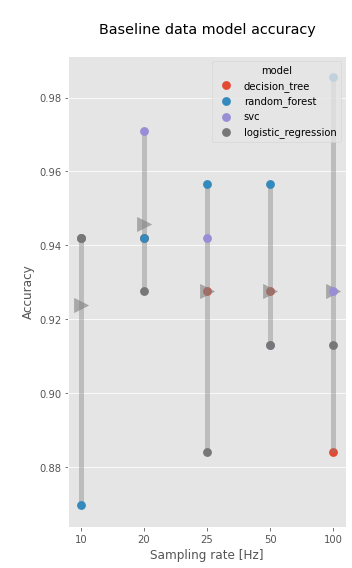

In [58]:
plt.figure(figsize=(5,8))
res_df_acc = pd.read_csv('output/baseline_model_accuracy.csv')

sns.pointplot(data=res_df_acc, x='hz', y='accuracy', hue='model', marker='o', linestyles='', zorder=3)
plt.title('\nBaseline data model accuracy\n');
plt.ylabel('\nAccuracy')
plt.xlabel('Sampling rate [Hz]')

for x in [(0,10), (1,20), (2,25), (3,50), (4, 100)]:
    plt.vlines(
        x=x[0], 
        ymin=res_df_acc[res_df_acc['hz'] == x[1]]['accuracy'].min(), 
        ymax=res_df_acc[res_df_acc['hz'] == x[1]]['accuracy'].max(), 
        color='grey', 
        alpha=0.4,
        zorder=1,
        linewidth=5)
    plt.scatter(
        x=x[0],
        y=res_df_acc[res_df_acc['hz'] == x[1]]['accuracy'].mean(),
        marker='>',
        zorder=2,
        s=200,
        color='grey',
        alpha=0.6
    )
    
plt.tight_layout()

## Inference time testing

Comparing inference time of scikit-learn and m2c(pure-python) models. Models that will be used on ESP32 will be the ones generated by m2c - therefore I wanted to verify that inference times don't take too long.

In [30]:
from models.baseline.base.decision_tree import decision_tree_10hz, decision_tree_20hz, decision_tree_25hz, decision_tree_50hz, decision_tree_100hz
from models.baseline.base.random_forest import random_forest_10hz, random_forest_20hz, random_forest_25hz, random_forest_50hz, random_forest_100hz
from models.baseline.base.svc import svc_10hz, svc_20hz, svc_25hz, svc_50hz, svc_100hz
from models.baseline.base.logistic_regression import logistic_regression_10hz, logistic_regression_20hz, logistic_regression_25hz, logistic_regression_50hz, logistic_regression_100hz

In [33]:
# loading the datasets
test_data_10hz = pd.read_csv('data/transformed/20210529_v2_data_all_10hz.csv').reset_index(drop=True).drop(['label','shift'], axis=1).loc[0]
test_data_20hz = pd.read_csv('data/transformed/20210529_v2_data_all_20hz.csv').reset_index(drop=True).drop(['label','shift'], axis=1).loc[0]
test_data_25hz = pd.read_csv('data/transformed/20210529_v2_data_all_25hz.csv').reset_index(drop=True).drop(['label','shift'], axis=1).loc[0]
test_data_50hz = pd.read_csv('data/transformed/20210529_v2_data_all_50hz.csv').reset_index(drop=True).drop(['label','shift'], axis=1).loc[0]
test_data_100hz = pd.read_csv('data/transformed/20210529_v2_data_all_100hz.csv').reset_index(drop=True).drop(['label','shift'], axis=1).loc[0]

In [34]:
test_data_10hz.shape, test_data_20hz.shape, test_data_25hz.shape, test_data_50hz.shape, test_data_100hz.shape

((66,), (126,), (156,), (306,), (606,))

## Running inference time testing on m2c(pure-python) models

In [35]:
from statistics import mean

m2c_time_test_setup = {
    'decision_tree': [
        (decision_tree_10hz, test_data_10hz, 10),
        (decision_tree_20hz, test_data_20hz, 20),
        (decision_tree_25hz, test_data_25hz, 25),
        (decision_tree_50hz, test_data_50hz, 50),
        (decision_tree_100hz, test_data_100hz, 100)
    ],
    'random_forest': [
        (random_forest_10hz, test_data_10hz, 10),
        (random_forest_20hz, test_data_20hz, 20),
        (random_forest_25hz, test_data_25hz, 25),
        (random_forest_50hz, test_data_50hz, 50),
        (random_forest_100hz, test_data_100hz, 100)
    ],
    'svc': [
        (svc_10hz, test_data_10hz, 10),
        (svc_20hz, test_data_20hz, 20),
        (svc_25hz, test_data_25hz, 25),
        (svc_50hz, test_data_50hz, 50),
        (svc_100hz, test_data_100hz, 100)
    ],
    'logistic_regression': [
        (logistic_regression_10hz, test_data_10hz, 10),
        (logistic_regression_20hz, test_data_20hz, 20),
        (logistic_regression_25hz, test_data_25hz, 25),
        (logistic_regression_50hz, test_data_50hz, 50),
        (logistic_regression_100hz, test_data_100hz, 100)
    ]
}

m2c_time_data = {}            

for k, v in m2c_time_test_setup.items():
    m2c_time_data[k] = {}
    for t_item in v:
        model = t_item[0]
        test_data = t_item[1]
        freq = t_item[2]
        res_time = get_ipython().run_line_magic('timeit', '-o model.score(test_data)')

        m2c_time_data[k][freq] = mean(res_time.timings)

6.56 µs ± 143 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
4.97 µs ± 83.9 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
4.88 µs ± 23.4 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
4.83 µs ± 24.2 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
3.33 µs ± 27.3 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
30.2 µs ± 432 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
32.8 µs ± 694 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
27.5 µs ± 781 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
29.7 µs ± 65.7 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
25.6 µs ± 253 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
434 µs ± 5.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
840 µs ± 6.54 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
1.04 ms ± 14.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
2.04 ms ± 30.6 µs per loop (mean ± std. dev.

In [36]:
m2c_time_df = pd.DataFrame(m2c_time_data) # create dataframe
skl_time_df = res_df.applymap(lambda x: mean(x['time'])).T # calculate mean time

In [59]:
m2c_time_df['framework'] = 'pure-python' # add label
skl_time_df['framework'] = 'scikit' # add label

inf_time_df = pd.concat([m2c_time_df, skl_time_df]).reset_index().rename(columns={'index':'hz'})
inf_time_df.to_csv('output/baseline_results/baseline_model_inference_time.csv', index=False)

## Plotting inference times for each model

Logistic regression & SVC doesn't scale well with the increasing number of inputs. Inference time takes ~ 4 ms on a MBP. ESP32 is a microcontroller with 240MHz of clock speed - thus I am excluding LR nad SVC from futher experiments. As they will most likely will be unusable on ESP.

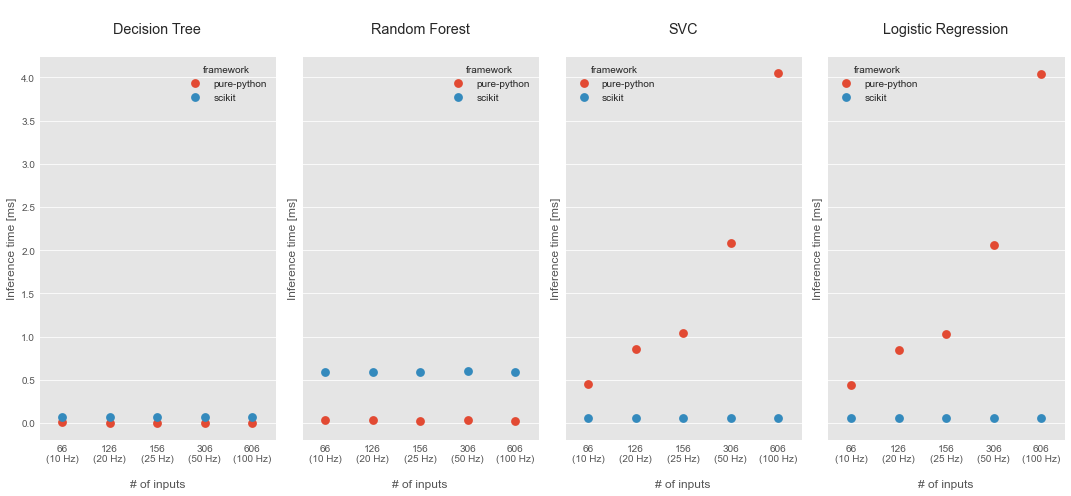

In [119]:
import matplotlib.ticker as tick

# load data
inf_time_df = pd.read_csv('output/baseline_model_inference_time.csv')
inf_time_df[['decision_tree', 'random_forest','svc','logistic_regression']] = inf_time_df[['decision_tree', 'random_forest','svc','logistic_regression']] * 1000

inf_t_dt = inf_time_df[['hz','decision_tree','framework']].rename(columns={'decision_tree':'time'})
inf_t_rf = inf_time_df[['hz','random_forest','framework']].rename(columns={'random_forest':'time'})
inf_t_svc = inf_time_df[['hz','svc','framework']].rename(columns={'svc':'time'})
inf_t_lr = inf_time_df[['hz','logistic_regression','framework']].rename(columns={'logistic_regression':'time'})

fig, ax = plt.subplots(ncols=4, sharey=True, figsize=(15,7))
plt.title('Inference times')

for i , data in enumerate([inf_t_dt, inf_t_rf, inf_t_svc, inf_t_lr]):
    sns.pointplot(x='hz', y='time', hue='framework', data=data, ax=ax[i], linestyles='')
    
#     for x in [(0,10),(1,20), (2, 25), (3,50), (4,100)]:
#         ax[i].vlines(
#                 x=x[0], 
#                 ymin=data[data['hz'] == x[1]]['time'].min(), 
#                 ymax=data[data['hz'] == x[1]]['time'].max(), 
#                 color='grey', 
#                 alpha=0.4,
#                 zorder=0,
#                 linewidth=5)

    
for i, clf in enumerate(['Decision Tree', 'Random Forest', 'SVC', 'Logistic Regression']):
    ax[i].title.set_text(f'\n{clf}\n')
    ax[i].set_ylabel('Inference time [ms]')
    ax[i].set_xticklabels(['66\n(10 Hz)', '126\n(20 Hz)', '156\n(25 Hz)', '306\n(50 Hz)', '606\n(100 Hz)'])
    ax[i].set_xlabel('\n# of inputs')
    


# plt.gca().yaxis.set_major_formatter(tick.FuncFormatter(lambda x, post: f'{(x * 1000)}'))
plt.tight_layout()

## Training on dataset with different labelling approach

#### Training with centered X and Y movements

In [26]:
res = {}

DATASET='centered'
DATASET_FUNC = get_df_center


for hz in [10,20,25,50,100]:
    print(f'\nTraining on dataset with {hz} Hz')
    print('*' * 50)
    print('\n')
    df = pd.read_csv(f'data/transformed/20210529_v2_data_all_{hz}hz.csv').reset_index(drop=True)
    
    df_train = DATASET_FUNC(df)

    print('DF Shape', df_train.shape)
    X_train, X_test, y_train, y_test = train_test_split(df_train.drop(['label','shift'],axis=1), df_train['label'], test_size=0.3, random_state=42)

    results = run_training(
                    X_train, X_test, y_train, y_test,
                    stage='baseline',
                    dataset=DATASET,
                    hz=hz,
                    collect_time=False,
                    is_save_model=True
                    )

    res[hz] = results

res_df = pd.DataFrame(res)
res_df.to_csv(f'output/baseline_results/baseline_{DATASET}_dataset_results.csv', index=False)


Training on dataset with 10 Hz
**************************************************


DF Shape (228, 68)


decision_tree 10 Hz


random_forest 10 Hz


svc 10 Hz


logistic_regression 10 Hz

Training on dataset with 20 Hz
**************************************************


DF Shape (228, 128)


decision_tree 20 Hz


random_forest 20 Hz


svc 20 Hz


logistic_regression 20 Hz

Training on dataset with 25 Hz
**************************************************


DF Shape (228, 158)


decision_tree 25 Hz


random_forest 25 Hz


svc 25 Hz


logistic_regression 25 Hz

Training on dataset with 50 Hz
**************************************************


DF Shape (228, 308)


decision_tree 50 Hz


random_forest 50 Hz


svc 50 Hz


logistic_regression 50 Hz

Training on dataset with 100 Hz
**************************************************


DF Shape (228, 608)


decision_tree 100 Hz


random_forest 100 Hz


svc 100 Hz


logistic_regression 100 Hz


#### Training with centered X and Y movements + Augmentation

In [27]:
res = {}

DATASET='centered_aug'
DATASET_FUNC = get_df_center_aug


for hz in [10,20,25,50,100]:
    print(f'\nTraining on dataset with {hz} Hz')
    print('*' * 50)
    print('\n')
    df = pd.read_csv(f'data/transformed/20210529_v2_data_all_{hz}hz.csv').reset_index(drop=True)
    
    df_train = DATASET_FUNC(df)

    print('DF Shape', df_train.shape)
    X_train, X_test, y_train, y_test = train_test_split(df_train.drop(['label','shift'],axis=1), df_train['label'], test_size=0.3, random_state=42)

    results = run_training(
                    X_train, X_test, y_train, y_test,
                    stage='baseline',
                    dataset=DATASET,
                    hz=hz,
                    collect_time=False,
                    is_save_model=True
                    )

    res[hz] = results

res_df = pd.DataFrame(res)
res_df.to_csv(f'output/baseline_results/baseline_{DATASET}_dataset_results.csv', index=False)


Training on dataset with 10 Hz
**************************************************


DF Shape (1112, 68)


decision_tree 10 Hz


random_forest 10 Hz


svc 10 Hz
/Users/tk/opt/miniconda3/envs/tinyml/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


logistic_regression 10 Hz

Training on dataset with 20 Hz
**************************************************


DF Shape (1112, 128)


decision_tree 20 Hz


random_forest 20 Hz


svc 20 Hz
/Users/tk/opt/miniconda3/envs/tinyml/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


logistic_regression 20 Hz

Training on dataset with 25 Hz
**************************************************


DF Shape (1112, 158)


decision_tree 25 Hz


random_forest 25 Hz


s

#### Training with X and Y movements at the end of labelling window

In [28]:
res = {}

DATASET='end'
DATASET_FUNC = get_df_end


for hz in [10,20,25,50,100]:
    print(f'\nTraining on dataset with {hz} Hz')
    print('*' * 50)
    print('\n')
    df = pd.read_csv(f'data/transformed/20210529_v2_data_all_{hz}hz.csv').reset_index(drop=True)
    
    df_train = DATASET_FUNC(df)

    print('DF Shape', df_train.shape)
    X_train, X_test, y_train, y_test = train_test_split(df_train.drop(['label','shift'],axis=1), df_train['label'], test_size=0.3, random_state=42)

    results = run_training(
                    X_train, X_test, y_train, y_test,
                    stage='baseline',
                    dataset=DATASET,
                    hz=hz,
                    collect_time=False,
                    is_save_model=True
                    )

    res[hz] = results

res_df = pd.DataFrame(res)
res_df.to_csv(f'output/baseline_results/baseline_{DATASET}_dataset_results.csv', index=False)


Training on dataset with 10 Hz
**************************************************


DF Shape (228, 68)


decision_tree 10 Hz


random_forest 10 Hz


svc 10 Hz
/Users/tk/opt/miniconda3/envs/tinyml/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


logistic_regression 10 Hz

Training on dataset with 20 Hz
**************************************************


DF Shape (228, 128)


decision_tree 20 Hz


random_forest 20 Hz


svc 20 Hz


logistic_regression 20 Hz

Training on dataset with 25 Hz
**************************************************


DF Shape (228, 158)


decision_tree 25 Hz


random_forest 25 Hz


svc 25 Hz


logistic_regression 25 Hz

Training on dataset with 50 Hz
**************************************************


DF Shape (228, 308)


decision_tree 50 Hz


random_forest 50 Hz


svc 50 Hz


logistic_regression 50 Hz

Training o

#### Training with centered X and Y movements + SMOTE

In [30]:
from imblearn.over_sampling import SMOTEN

res = {}

DATASET='centered_smote'
DATASET_FUNC = get_df_center


for hz in [10,20,25,50,100]:
    print(f'\nTraining on dataset with {hz} Hz')
    print('*' * 50)
    print('\n')
    df = pd.read_csv(f'data/transformed/20210529_v2_data_all_{hz}hz.csv').reset_index(drop=True)
    
    df_train = DATASET_FUNC(df)


    print('DF Shape', df_train.shape)
    X_train, X_test, y_train, y_test = train_test_split(df_train.drop(['label','shift'],axis=1), df_train['label'], test_size=0.3, random_state=42)


    over_sampler = SMOTEN(k_neighbors=2, sampling_strategy='not majority', random_state=42)
    X_train_SMOTE, y_train_SMOTE = over_sampler.fit_resample(X_train, y_train)

    results = run_training(
                    X_train_SMOTE, X_test, y_train_SMOTE, y_test,
                    stage='baseline',
                    dataset=DATASET,
                    hz=hz,
                    collect_time=False,
                    is_save_model=True
                    )

    res[hz] = results

res_df = pd.DataFrame(res)
res_df.to_csv(f'output/baseline_results/baseline_{DATASET}_dataset_results.csv', index=False)


Training on dataset with 10 Hz
**************************************************


DF Shape (228, 68)


decision_tree 10 Hz


random_forest 10 Hz


svc 10 Hz


logistic_regression 10 Hz
/Users/tk/opt/miniconda3/envs/tinyml/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "

Training on dataset with 20 Hz
**************************************************


DF Shape (228, 128)


decision_tree 20 Hz


random_forest 20 Hz


svc 20 Hz


logistic_regression 20 Hz

Training on dataset with 25 Hz
**************************************************


DF Shape (228, 158)


decision_tree 25 Hz


random_forest 25 Hz


svc 25 Hz


logistic_regression 25 Hz

Training on dataset with 50 Hz
**************************************************


DF Shape (228, 308)


decision_tree 50 Hz


random_forest 50 Hz


svc 50 Hz


logistic_regression 50 Hz

Training o